In [1]:
# 다른 경로에 있는 모듈을 가져오기 위해 절대 경로 추가

import os
import sys

root = os.path.join(os.path.abspath(os.getcwd()), '..', '..')
root = os.path.normpath(root)

if root not in sys.path:
    sys.path.insert(0, root)

In [2]:
# 필요한 라이브러리 로드

import json
import matplotlib.pyplot as plt
import pandas as pd
import torch
from communav.utils import db
from sklearn.metrics import accuracy_score, fbeta_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup

/tmp/ipykernel_13897/1570002022.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/home/retn0/repositories/nbsp1221/communav/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 카테고리 정의

CATEGORIES = {
    1: '질문 · 답변',
    2: '학사 · 졸업',
    3: '장학 · 행정',
    4: '학교생활',
    5: '수업/이과',
    6: '수업/문과',
    7: '캠퍼스',
    8: '일상생활',
    9: '취미 · 여가',
    10: '인간관계',
    11: '취업 · 진로',
}

In [4]:
# 파라미터 설정

MODEL_ID = 'beomi/KcELECTRA-base-v2022'
MAX_LENGTH = 128
F_BETA = 0.5
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 2e-5
TARGET_CATEGORY = 6

In [5]:
# 커뮤니티 게시글 데이터 로드

connection = db.get_connection()
cursor = connection.cursor()

cursor.execute('''
    SELECT
        articles.id,
        articles.title,
        articles.text,
        labels.category_ids
    FROM everytime_original_articles articles
    JOIN everytime_article_labels labels ON articles.id = labels.article_id
''')
original_articles = cursor.fetchall()
print(f'Loaded {len(original_articles)} articles.')

cursor.close()
db.close_connection()

Connected to DB successfully.
Loaded 2392 articles.


In [6]:
# 가져온 데이터의 일부를 출력

for article in original_articles[:20]:
    print(article)

{'id': 100245988, 'title': '장학금 관련해서..', 'text': '성적장학금 + 한울장학금 가능한지 궁금합니다..', 'category_ids': '[1, 3]'}
{'id': 100634300, 'title': '배고파 집에가서', 'text': '진짬뽕에 밥 말아먹어야지 히힣', 'category_ids': '[]'}
{'id': 100656956, 'title': '부산 + 용인까지 의심 환자 발생', 'text': '평택시는 난리남.\n부산에서도..\n근데 이상한건 용인인데.\n그 분은 중국 갔다온사람 아니라던데?\n뭐냐 진짜..', 'category_ids': '[]'}
{'id': 100682214, 'title': '신종 코로나바이러스(2019-nCoV) 감염증 대처 방법', 'text': "원문은 의과교수 펨붕이가 펨코에 쓴 것. 지금도 질문받는듯.\n \n==========================================\n최근 우한에서 발생한 신종 코로나바이러스(2019-nCoV) 감염증으로 인해서 많은 우려를 가지고 계실 듯합니다. \n여러 인터넷 커뮤니티에서 많은 정보들이 돌아다니고, 이로 인해 혼란이 가중되는 모습을 연휴 동안 지켜보았습니다. \n \n저는 예방의학전문의로 현재 의과대학에서 교수로 일하고 있습니다. 감염내과 전공은 아니지만, 2015년부터 신종 감염병과 관련된 여러 경험이 있고, 메르스, 지카바이러스 감염증 등 신종감염병 유입 사례에서 정부 내에서 역학조사팀장으로도 일했습니다. 이후 여러 감염병과 관련된 학술적인 작업을 하고 있습니다.\n \n개인적으로는 다행히도 재작년에 교직으로 옮기면서 현장 대응과는 거리가 멀어졌지만, 여러분들에게 정확한 정보를 알려드리고, 위험 의사소통(Risk communication)을 적극적으로 수행하는 것이 얼마나 중요한지 잘 알고 있어서 현장에서 고생하시는 분들을 대신해서 소통에 나서게 되었습니다. 현재 이러한 업무를 수행하실 수 있는 능력을 가지신 훌륭한 

In [7]:
# 이진 분류 문제를 위한 데이터 전처리

preprocessed_articles = []

for article in original_articles:
    title = article['title']
    text = article['text']
    content = (title + ' ' + text).replace('\n', ' ').strip()
    label = 1 if TARGET_CATEGORY in json.loads(article['category_ids']) else 0

    preprocessed_articles.append({
        'content': content,
        'label': label
    })

In [8]:
# 전처리된 데이터의 일부를 출력

for article in preprocessed_articles[:20]:
    print(article)

{'content': '장학금 관련해서.. 성적장학금 + 한울장학금 가능한지 궁금합니다..', 'label': 0}
{'content': '배고파 집에가서 진짬뽕에 밥 말아먹어야지 히힣', 'label': 0}
{'content': '부산 + 용인까지 의심 환자 발생 평택시는 난리남. 부산에서도.. 근데 이상한건 용인인데. 그 분은 중국 갔다온사람 아니라던데? 뭐냐 진짜..', 'label': 0}
{'content': "신종 코로나바이러스(2019-nCoV) 감염증 대처 방법 원문은 의과교수 펨붕이가 펨코에 쓴 것. 지금도 질문받는듯.   ========================================== 최근 우한에서 발생한 신종 코로나바이러스(2019-nCoV) 감염증으로 인해서 많은 우려를 가지고 계실 듯합니다.  여러 인터넷 커뮤니티에서 많은 정보들이 돌아다니고, 이로 인해 혼란이 가중되는 모습을 연휴 동안 지켜보았습니다.    저는 예방의학전문의로 현재 의과대학에서 교수로 일하고 있습니다. 감염내과 전공은 아니지만, 2015년부터 신종 감염병과 관련된 여러 경험이 있고, 메르스, 지카바이러스 감염증 등 신종감염병 유입 사례에서 정부 내에서 역학조사팀장으로도 일했습니다. 이후 여러 감염병과 관련된 학술적인 작업을 하고 있습니다.   개인적으로는 다행히도 재작년에 교직으로 옮기면서 현장 대응과는 거리가 멀어졌지만, 여러분들에게 정확한 정보를 알려드리고, 위험 의사소통(Risk communication)을 적극적으로 수행하는 것이 얼마나 중요한지 잘 알고 있어서 현장에서 고생하시는 분들을 대신해서 소통에 나서게 되었습니다. 현재 이러한 업무를 수행하실 수 있는 능력을 가지신 훌륭한 분들께서는 대부분 현장에서 나가 계셔서 저처럼 자리에 앉아 있으실 수 없을듯 합니다.     1. 신종 코로나 바이러스 감염증에 대해서 궁금하신 것이 있으시면 무엇이든 질문해주세요. 적극적으로 정보를 찾아서 제공해드리겠습니다. 어떠한 질문이든 관계없습니다. : 제가 2

In [9]:
# 데이터 분포 확인 함수 정의

def plot_distribution(articles):
    label_counts = [0, 0]
    for article in articles:
        label_counts[article['label']] += 1

    total_count = sum(label_counts)
    percentages = [count / total_count * 100 for count in label_counts]
    for i, percentage in enumerate(percentages):
        print(f'Label {i}: {percentage:.2f}%')

    plt.figure(figsize=(8, 6))
    plt.bar(['0', '1'], label_counts)
    plt.text(0, label_counts[0] + 0.1, str(label_counts[0]), ha='center')
    plt.text(1, label_counts[1] + 0.1, str(label_counts[1]), ha='center')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title('Distribution of Labels')
    plt.show()

Label 0: 87.75%
Label 1: 12.25%


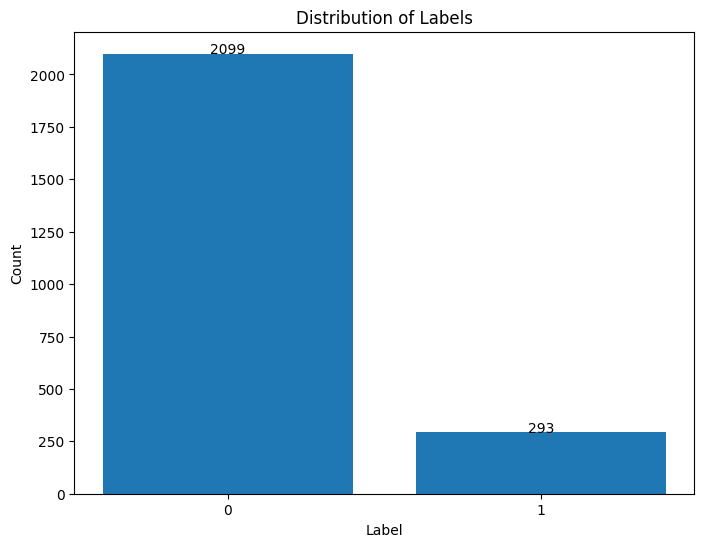

In [10]:
# 데이터 분포 확인

plot_distribution(preprocessed_articles)

In [11]:
# 훈련 데이터와 검증 데이터로 분리

train_articles, val_articles = train_test_split(
    preprocessed_articles,
    test_size=0.2,
    random_state=42
)

print(f'Number of training articles: {len(train_articles)}')
print(f'Number of validation articles: {len(val_articles)}')

Number of training articles: 1913
Number of validation articles: 479


Label 0: 87.25%
Label 1: 12.75%


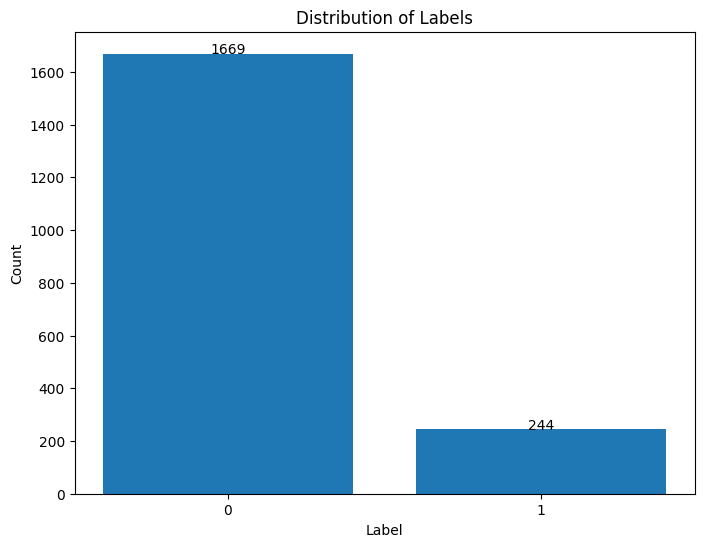

In [12]:
# 훈련 데이터의 데이터 분포 확인

plot_distribution(train_articles)

Label 0: 89.77%
Label 1: 10.23%


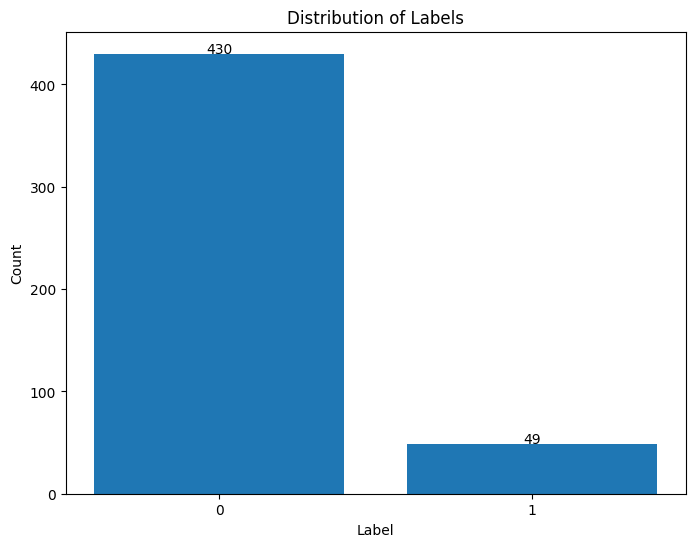

In [13]:
# 검증 데이터의 데이터 분포 확인

plot_distribution(val_articles)

In [14]:
# 토크나이저 로드

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

print('Original:', preprocessed_articles[0]['content'])
print('Tokenized:', tokenizer.tokenize(preprocessed_articles[0]['content']))

Original: 장학금 관련해서.. 성적장학금 + 한울장학금 가능한지 궁금합니다..
Tokenized: ['장학금', '관련해서', '.', '.', '성적', '##장', '##학', '##금', '+', '한울', '##장', '##학', '##금', '가능한', '##지', '궁금합니다', '.', '.']


In [15]:
# 모델 로드

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print('No GPU available, using the CPU instead.')

model = AutoModelForSequenceClassification.from_pretrained(MODEL_ID, num_labels=2)
model.to(device)

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3060 Ti


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(54343, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [16]:
# 텍스트 인코딩 및 데이터셋 생성

train_contents = [article['content'] for article in train_articles]
train_labels = [article['label'] for article in train_articles]
val_contents = [article['content'] for article in val_articles]
val_labels = [article['label'] for article in val_articles]

train_encodings = tokenizer(
    train_contents,
    padding=True,
    truncation=True,
    return_tensors='pt',
    max_length=MAX_LENGTH
)
val_encodings = tokenizer(
    val_contents,
    padding=True,
    truncation=True,
    return_tensors='pt',
    max_length=MAX_LENGTH
)

train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(train_labels)
)
val_dataset = torch.utils.data.TensorDataset(
    torch.tensor(val_encodings['input_ids']),
    torch.tensor(val_encodings['attention_mask']),
    torch.tensor(val_labels)
)

/tmp/ipykernel_13897/3075390715.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(train_encodings['input_ids']),
/tmp/ipykernel_13897/3075390715.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(train_encodings['attention_mask']),
/tmp/ipykernel_13897/3075390715.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(val_encodings['input_ids']),
/tmp/ipykernel_13897/3075390715.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTenso

In [17]:
# 학습 전 초기화

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_dataset) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_accs = []
train_precs = []
train_recs = []
train_f_betas = []
train_losses = []

val_accs = []
val_precs = []
val_recs = []
val_f_betas = []
val_losses = []

In [18]:
# 평가 지표 계산 함수 정의

def calculate_metrics(true_labels, predicted_labels):
    acc = accuracy_score(true_labels, predicted_labels)
    prec = precision_score(true_labels, predicted_labels)
    rec = recall_score(true_labels, predicted_labels)
    f_beta = fbeta_score(true_labels, predicted_labels, beta=F_BETA)

    return acc, prec, rec, f_beta

In [19]:
# 학습 시작

best_val_f_beta = 0.0
best_model_path = None

for epoch in range(EPOCHS):
    model.train()

    train_loss = 0.0
    train_predictions = []
    train_labels_epoch = []

    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1} - Training'):
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        train_predictions.extend(predictions.tolist())
        train_labels_epoch.extend(labels.tolist())

    train_acc, train_prec, train_rec, train_f_beta = calculate_metrics(train_labels_epoch, train_predictions)
    train_accs.append(train_acc)
    train_precs.append(train_prec)
    train_recs.append(train_rec)
    train_f_betas.append(train_f_beta)
    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)

    model.eval()

    val_loss = 0.0
    val_predictions = []

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc=f'Epoch {epoch + 1} - Validation'):
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)

            val_predictions.extend(predictions.tolist())

    val_acc, val_prec, val_rec, val_f_beta = calculate_metrics(val_labels, val_predictions)
    val_accs.append(val_acc)
    val_precs.append(val_prec)
    val_recs.append(val_rec)
    val_f_betas.append(val_f_beta)
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)

    print(f'Epoch {epoch + 1}:')
    print(f'  Train Acc = {train_acc:.4f}, Train Prec = {train_prec:.4f}, Train Rec = {train_rec:.4f}, Train F-Beta = {train_f_beta:.4f}, Train Loss = {train_loss:.4f}')
    print(f'  Val Acc = {val_acc:.4f}, Val Prec = {val_prec:.4f}, Val Rec = {val_rec:.4f}, Val F-Beta = {val_f_beta:.4f}, Val Loss = {val_loss:.4f}')

    if val_f_beta > best_val_f_beta:
        best_val_f_beta = val_f_beta
        best_model_path = f'model-{epoch + 1}-{best_val_f_beta:.4f}'
        model.save_pretrained(best_model_path)
        tokenizer.save_pretrained(best_model_path)
        print(f'  Best model saved with {best_val_f_beta:.4f} F-beta score.')

print('Training finished.')

Epoch 1 - Validation: 100%|██████████| 15/15 [00:01<00:00, 10.09it/s]
/home/retn0/repositories/nbsp1221/communav/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1:
  Train Acc = 0.8552, Train Prec = 0.0769, Train Rec = 0.0123, Train F-Beta = 0.0375, Train Loss = 0.4071
  Val Acc = 0.8977, Val Prec = 0.0000, Val Rec = 0.0000, Val F-Beta = 0.0000, Val Loss = 0.2944


Epoch 2 - Validation: 100%|██████████| 15/15 [00:01<00:00, 10.05it/s]


Epoch 2:
  Train Acc = 0.9007, Train Prec = 0.7812, Train Rec = 0.3074, Train F-Beta = 0.5971, Train Loss = 0.2481
  Val Acc = 0.9457, Val Prec = 0.7949, Val Rec = 0.6327, Val F-Beta = 0.7561, Val Loss = 0.1614
  Best model saved with 0.7561 F-beta score.


Epoch 3 - Validation: 100%|██████████| 15/15 [00:01<00:00, 10.02it/s]


Epoch 3:
  Train Acc = 0.9655, Train Prec = 0.8589, Train Rec = 0.8730, Train F-Beta = 0.8617, Train Loss = 0.1096
  Val Acc = 0.9436, Val Prec = 0.8929, Val Rec = 0.5102, Val F-Beta = 0.7764, Val Loss = 0.2132
  Best model saved with 0.7764 F-beta score.


Epoch 4 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.99it/s]


Epoch 4:
  Train Acc = 0.9660, Train Prec = 0.8776, Train Rec = 0.8525, Train F-Beta = 0.8725, Train Loss = 0.0964
  Val Acc = 0.9520, Val Prec = 0.8611, Val Rec = 0.6327, Val F-Beta = 0.8031, Val Loss = 0.1358
  Best model saved with 0.8031 F-beta score.


Epoch 5 - Validation: 100%|██████████| 15/15 [00:01<00:00, 10.01it/s]


Epoch 5:
  Train Acc = 0.9895, Train Prec = 0.9516, Train Rec = 0.9672, Train F-Beta = 0.9547, Train Loss = 0.0391
  Val Acc = 0.9499, Val Prec = 0.8571, Val Rec = 0.6122, Val F-Beta = 0.7937, Val Loss = 0.2458


Epoch 6 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.97it/s]


Epoch 6:
  Train Acc = 0.9958, Train Prec = 0.9720, Train Rec = 0.9959, Train F-Beta = 0.9767, Train Loss = 0.0206
  Val Acc = 0.9499, Val Prec = 0.8049, Val Rec = 0.6735, Val F-Beta = 0.7746, Val Loss = 0.2301


Epoch 7 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.75it/s]


Epoch 7:
  Train Acc = 0.9974, Train Prec = 0.9799, Train Rec = 1.0000, Train F-Beta = 0.9839, Train Loss = 0.0118
  Val Acc = 0.9415, Val Prec = 0.8889, Val Rec = 0.4898, Val F-Beta = 0.7643, Val Loss = 0.3405


Epoch 8 - Validation: 100%|██████████| 15/15 [00:01<00:00, 10.01it/s]


Epoch 8:
  Train Acc = 0.9948, Train Prec = 0.9680, Train Rec = 0.9918, Train F-Beta = 0.9727, Train Loss = 0.0204
  Val Acc = 0.9520, Val Prec = 0.8095, Val Rec = 0.6939, Val F-Beta = 0.7834, Val Loss = 0.2487


Epoch 9 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.94it/s]


Epoch 9:
  Train Acc = 0.9969, Train Prec = 0.9798, Train Rec = 0.9959, Train F-Beta = 0.9830, Train Loss = 0.0129
  Val Acc = 0.9436, Val Prec = 0.7895, Val Rec = 0.6122, Val F-Beta = 0.7463, Val Loss = 0.3002


Epoch 10 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.85it/s]


Epoch 10:
  Train Acc = 0.9932, Train Prec = 0.9714, Train Rec = 0.9754, Train F-Beta = 0.9722, Train Loss = 0.0215
  Val Acc = 0.9541, Val Prec = 0.8649, Val Rec = 0.6531, Val F-Beta = 0.8122, Val Loss = 0.2638
  Best model saved with 0.8122 F-beta score.


Epoch 11 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Epoch 11:
  Train Acc = 0.9969, Train Prec = 0.9837, Train Rec = 0.9918, Train F-Beta = 0.9853, Train Loss = 0.0067
  Val Acc = 0.9499, Val Prec = 0.8571, Val Rec = 0.6122, Val F-Beta = 0.7937, Val Loss = 0.3232


Epoch 12 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.85it/s]


Epoch 12:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0014
  Val Acc = 0.9562, Val Prec = 0.8684, Val Rec = 0.6735, Val F-Beta = 0.8209, Val Loss = 0.3128
  Best model saved with 0.8209 F-beta score.


Epoch 13 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.81it/s]


Epoch 13:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0010
  Val Acc = 0.9520, Val Prec = 0.8250, Val Rec = 0.6735, Val F-Beta = 0.7895, Val Loss = 0.3225


Epoch 14 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.82it/s]


Epoch 14:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0008
  Val Acc = 0.9520, Val Prec = 0.8611, Val Rec = 0.6327, Val F-Beta = 0.8031, Val Loss = 0.3456


Epoch 15 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.87it/s]


Epoch 15:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0008
  Val Acc = 0.9520, Val Prec = 0.8250, Val Rec = 0.6735, Val F-Beta = 0.7895, Val Loss = 0.3325


Epoch 16 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.92it/s]


Epoch 16:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0007
  Val Acc = 0.9499, Val Prec = 0.8571, Val Rec = 0.6122, Val F-Beta = 0.7937, Val Loss = 0.3776


Epoch 17 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.92it/s]


Epoch 17:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0005
  Val Acc = 0.9520, Val Prec = 0.8421, Val Rec = 0.6531, Val F-Beta = 0.7960, Val Loss = 0.3442


Epoch 18 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.92it/s]


Epoch 18:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0005
  Val Acc = 0.9541, Val Prec = 0.8462, Val Rec = 0.6735, Val F-Beta = 0.8049, Val Loss = 0.3378


Epoch 19 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.90it/s]


Epoch 19:
  Train Acc = 0.9990, Train Prec = 0.9959, Train Rec = 0.9959, Train F-Beta = 0.9959, Train Loss = 0.0033
  Val Acc = 0.9457, Val Prec = 0.8710, Val Rec = 0.5510, Val F-Beta = 0.7803, Val Loss = 0.4178


Epoch 20 - Validation: 100%|██████████| 15/15 [00:01<00:00,  9.90it/s]


Epoch 20:
  Train Acc = 0.9948, Train Prec = 0.9795, Train Rec = 0.9795, Train F-Beta = 0.9795, Train Loss = 0.0143
  Val Acc = 0.9541, Val Prec = 0.8140, Val Rec = 0.7143, Val F-Beta = 0.7919, Val Loss = 0.2191
Training finished.


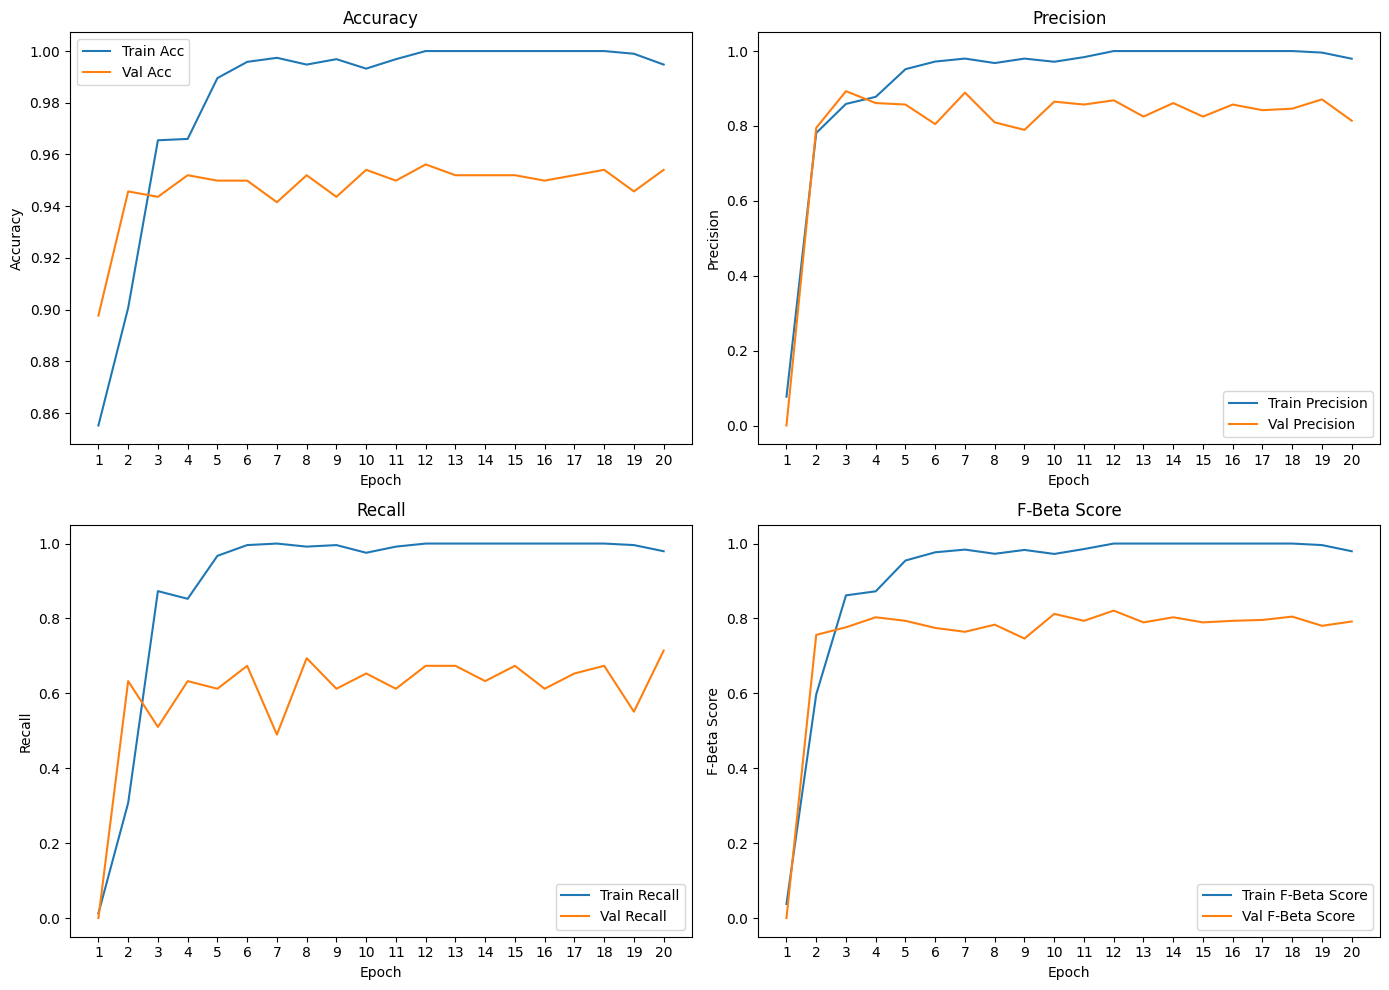

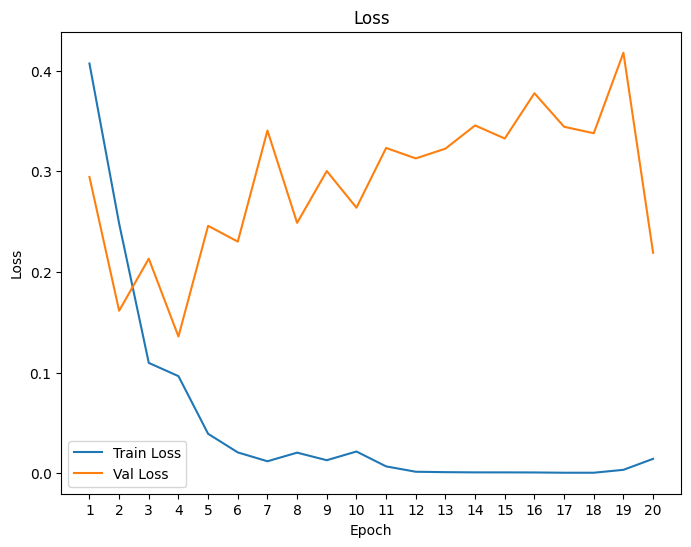

In [20]:
# 학습 결과 시각화

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.xticks(range(len(train_accs)), range(1, len(train_accs) + 1))
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(2, 2, 2)
plt.plot(train_precs, label='Train Precision')
plt.plot(val_precs, label='Val Precision')
plt.xlabel('Epoch')
plt.xticks(range(len(train_precs)), range(1, len(train_precs) + 1))
plt.ylabel('Precision')
plt.legend()
plt.title('Precision')

plt.subplot(2, 2, 3)
plt.plot(train_recs, label='Train Recall')
plt.plot(val_recs, label='Val Recall')
plt.xlabel('Epoch')
plt.xticks(range(len(train_recs)), range(1, len(train_recs) + 1))
plt.ylabel('Recall')
plt.legend()
plt.title('Recall')

plt.subplot(2, 2, 4)
plt.plot(train_f_betas, label='Train F-Beta Score')
plt.plot(val_f_betas, label='Val F-Beta Score')
plt.xlabel('Epoch')
plt.xticks(range(len(train_f_betas)), range(1, len(train_f_betas) + 1))
plt.ylabel('F-Beta Score')
plt.legend()
plt.title('F-Beta Score')

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.xticks(range(len(train_losses)), range(1, len(train_losses) + 1))
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [21]:
# 평가

model = AutoModelForSequenceClassification.from_pretrained(best_model_path, num_labels=2)
model.to(device)

predictions = [
    # 질문 · 답변
    '학교에서 제공하는 심리 상담 서비스가 어떤 것들이 있나요?',
    '대학교 1학년 때 교양 과목으로 추천할 만한 강의가 있을까요?',
    '학교 도서관에서 책을 대출하는 방법이 궁금합니다. 알려주실 수 있나요?',
    '학교에서 운영하는 학생 지원 프로그램에는 어떤 것들이 있나요?',
    '교내 봉사활동 기회에 대해 더 자세히 알고 싶습니다. 정보를 제공해 주시겠어요?',

    # 학사 · 졸업
    '이번 학기 수강 신청 일정이 언제인가요? 강의 계획서는 어디서 확인할 수 있을까요?',
    '복수 전공 신청 자격 요건과 절차가 궁금합니다. 자세히 설명해 주실 수 있나요?',
    '졸업 논문 제출 마감일이 언제인지 확인 부탁드립니다.',
    '전공 필수 과목과 선택 과목의 차이점이 무엇인가요? 수강 계획을 위해 알려주시면 감사하겠습니다.',
    '휴학 신청 방법과 유의사항에 대해 자세히 설명해 주시겠어요?',

    # 장학 · 행정
    '교내 장학금 신청 자격과 절차에 대해 알려주세요.',
    '국가 장학금 신청 기간과 필요한 서류가 무엇인지 궁금합니다.',
    '학자금 대출 상환 방법과 유예 조건에 대해 자세히 설명해 주시겠어요?',
    '전과 신청 자격과 절차가 어떻게 되나요? 상세한 안내 부탁드립니다.',
    '학생증 재발급 신청은 어떻게 하나요? 수수료가 있나요?',

    # 학교생활
    '교내에서 활동 중인 동아리에는 어떤 것들이 있나요? 동아리 소개 부탁드립니다.',
    '이번 학교 축제 일정과 프로그램이 궁금합니다. 정보 좀 알려주세요.',
    '교내 체육대회 참가 신청 방법과 일정이 어떻게 되나요?',
    '학생회에서 주최하는 이벤트와 캠페인에 대한 정보를 알려주실 수 있나요?',
    '교환학생 프로그램에 대해 더 자세히 알고 싶습니다. 정보 제공 부탁드려요.',

    # 수업/이과
    '이번 학기 물리학 수업 과제 제출 마감일이 언제인가요?',
    '미적분학 수업에서 배운 개념이 잘 이해되지 않습니다. 선배님들의 조언 부탁드려요.',
    '프로그래밍 언어 수업 수강을 고민하고 있는데, 파이썬과 자바 중 어떤 것을 추천하시나요?',
    '공학수학 시험 범위가 어디까지인지 확인 부탁드립니다.',
    '생물학 실험 수업을 들으려고 하는데, 실험복은 개별적으로 준비해야 하나요?',

    # 수업/문과
    '이번 학기 문학개론 수업 필독서 목록을 공유해 주시면 감사하겠습니다.',
    '철학 수업에서 다루는 주요 사상가들에 대해 간단히 소개해 주실 수 있나요?',
    '심리학 수업 팀 프로젝트 주제 선정에 대해 조언 부탁드립니다.',
    '역사학 수업 기말 리포트 분량과 참고문헌 작성 방법이 궁금합니다.',
    '언어학 수업에서 배운 개념들을 실생활에 적용하는 방법이 있을까요?',

    # 캠퍼스
    '학교 도서관 열람실 이용 시간과 좌석 예약 방법이 궁금합니다.',
    '학교 식당 메뉴와 운영 시간을 알려주시면 감사하겠습니다.',
    '기숙사 입사 신청 자격과 절차가 어떻게 되나요? 상세한 안내 부탁드립니다.',
    '체력단련실 이용 방법과 운영 시간에 대해 알고 싶습니다.',
    '교내 편의점 위치와 운영 시간을 알려주시겠어요?',

    # 일상생활
    '건강한 식단 관리를 위한 식습관 개선 팁을 공유해 주시면 감사하겠습니다.',
    '효과적인 시간 관리 방법과 일정 계획 앱 추천 부탁드립니다.',
    '자취생을 위한 저렴한 식재료 구매 장소와 요리 레시피 공유해 주세요.',
    '대학생 알바 경험이 있으신 분들, 시간 관리와 스트레스 해소 팁 좀 알려주시겠어요?',
    '병역 의무 관련 정보와 군 입대 시기 선택에 대한 조언 부탁드립니다.',

    # 취미 · 여가
    '강남에 가볼 만한 맛집이나 카페 추천해 주실 수 있나요?',
    '축구 활동에 관심이 있는데, 자세한 정보 좀 알려주시겠어요?',
    '기타 배우기 좋은 온라인 강의나 교재가 있다면 추천 부탁드립니다.',
    '가까운 여행지나 나들이 장소 추천해 주시면 감사하겠습니다.',
    '사진 촬영 팁과 포토샵 강좌 정보 공유 부탁드려요.',

    # 인간관계
    '대학교 새내기로서 선배님들과 좋은 관계를 맺는 방법이 있을까요?',
    '동아리나 팀 프로젝트에서 팀원들과 갈등이 생겼을 때 해결하는 방법 좀 알려주세요.',
    '친구들과 어색해졌을 때 관계 개선을 위한 조언 부탁드립니다.',
    '선배님들께 인사나 존경을 표현하는 적절한 방법이 있나요?',
    '성격 차이로 인한 친구와의 갈등을 해결하는 방법에 대해 조언 부탁드려요.',

    # 취업 · 진로
    '효과적인 대외활동과 인턴십 준비 방법에 대해 조언 부탁드립니다.',
    '전공과 관련된 자격증 취득을 위한 학습 계획 및 준비 과정이 궁금합니다.',
    '취업 면접에서 자주 나오는 질문들과 답변 팁 좀 알려주시겠어요?',
    'LinkedIn 프로필 작성과 활용 방법에 대한 조언 부탁드립니다.',
    '대학원 진학을 고민하고 있는데, 학업 계획과 준비 과정에 대해 알려주시면 감사하겠습니다.'
]

encodings = tokenizer(
    predictions,
    padding=True,
    truncation=True,
    return_tensors='pt',
    max_length=MAX_LENGTH
)
input_ids = encodings['input_ids'].to(device)
attention_mask = encodings['attention_mask'].to(device)

with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    predicted_labels = torch.argmax(logits, dim=1).tolist()

for text, label, probs in zip(predictions, predicted_labels, probabilities.tolist()):
    sentiment = CATEGORIES[TARGET_CATEGORY] if label == 1 else '그 외'
    print(f'텍스트: {text}')
    print(f'예측: {sentiment} {probs}')
    print()

텍스트: 학교에서 제공하는 심리 상담 서비스가 어떤 것들이 있나요?
예측: 그 외 [0.9997215867042542, 0.0002783699019346386]

텍스트: 대학교 1학년 때 교양 과목으로 추천할 만한 강의가 있을까요?
예측: 그 외 [0.9996635913848877, 0.0003363841969985515]

텍스트: 학교 도서관에서 책을 대출하는 방법이 궁금합니다. 알려주실 수 있나요?
예측: 그 외 [0.999711811542511, 0.00028817972633987665]

텍스트: 학교에서 운영하는 학생 지원 프로그램에는 어떤 것들이 있나요?
예측: 그 외 [0.9997338652610779, 0.0002661330800037831]

텍스트: 교내 봉사활동 기회에 대해 더 자세히 알고 싶습니다. 정보를 제공해 주시겠어요?
예측: 그 외 [0.9997633099555969, 0.00023675081320106983]

텍스트: 이번 학기 수강 신청 일정이 언제인가요? 강의 계획서는 어디서 확인할 수 있을까요?
예측: 그 외 [0.999710738658905, 0.0002891991753131151]

텍스트: 복수 전공 신청 자격 요건과 절차가 궁금합니다. 자세히 설명해 주실 수 있나요?
예측: 그 외 [0.9997559189796448, 0.00024413992650806904]

텍스트: 졸업 논문 제출 마감일이 언제인지 확인 부탁드립니다.
예측: 그 외 [0.9997630715370178, 0.00023691901878919452]

텍스트: 전공 필수 과목과 선택 과목의 차이점이 무엇인가요? 수강 계획을 위해 알려주시면 감사하겠습니다.
예측: 그 외 [0.9996947050094604, 0.0003053565160371363]

텍스트: 휴학 신청 방법과 유의사항에 대해 자세히 설명해 주시겠어요?
예측: 그 외 [0.999747097492218, 0.00025294694933108985]

텍스트: 교내 장학금 신청 자격과 절